In [44]:
import libraries
from libraries import *
%matplotlib inline

print(get_available_gpus())

# sys.stdout.flush()
print(psutil.virtual_memory())

reload(libraries)
from libraries import *

print(keras.__version__)

[]
svmem(total=17179869184, available=3952271360, percent=77.0, used=14315429888, free=811089920, active=7955431424, inactive=3141181440, wired=3218817024)
2.0.8


In [64]:
def load_data(split=0.8, path='../data/sushi_or_sandwich/', target_size=(256, 256), pil=False):
    
    flabs = (join(path, i) for i in listdir(path) if not isfile(join(path, i)))

    d_lab = {'sandwich': 0, 'sushi': 1}

    ims = np.empty(((0,) + target_size + (3,)))
    labs = np.empty((0,))

    for i in flabs:
        print(i)
        ims_gen = (join(i, j) for j in listdir(i) if isfile(join(i, j)))
        for j in ims_gen:
            print(j)
            if pil: im = img_to_array(load_img(j, target_size=target_size))
            else:
                im = cv2.imread(j).astype(np.float32)
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB) # b,g,r = cv2.split(im); im = cv2.merge([r,g,b]) 
                im = cv2.resize(im, target_size)

            ims = np.append(ims, im.reshape((1,) + im.shape), axis=0)
            labs = np.append(labs, (d_lab[i.split(path)[1]], ), axis=0)
    
    return preprocess_data(ims, labs, split)

In [5]:
path = '/Users/blanca_alonso/Documents/cookpad/data/sushi_or_sandwich/'
target_size = (256, 256)
pil=0

x_train, y_train, x_test, y_test, mean_set, std_set = load_data(path=path)
print(x_train.shape)

NameError: name 'os' is not defined

#### optimized data loading

In [43]:
def load_data_extended(split=0.8, path='../data/sushi_or_sandwich/', target_size=(256, 256), pil=False):

    fsplit = [join(path, i) for i in listdir(path) if not isfile(join(path, i))]

    d_lab = {'sandwich': 0, 'sushi': 1}
    ims = np.empty(((0,) + target_size + (3,)))
    labs = np.empty((0,))

    for i in fsplit:
        print(i)
        flabs = [join(i, j) for j in listdir(i) if not isfile(join(i, j))]    

        for j in flabs:
            print(j)
            ims_gen = (join(j, k) for k in listdir(j) if isfile(join(j, k)))

            for k in ims_gen:
                print(k)
                if pil: im = img_to_array(load_img(k, target_size=target_size))
                else:
                    im = cv2.imread(k).astype(np.float32)
                    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                    im = cv2.resize(im, target_size)

                ims = np.append(ims, im.reshape((1,) + im.shape), axis=0)
                labs = np.append(labs, (d_lab[j.split(i)[1].split('/')[1]], ), axis=0)
                
    return preprocess_data(ims, labs, split)

In [ ]:
path = '/Users/blanca_alonso/Documents/cookpad/data/sushi_or_sandwich/'
target_size = (256, 256)

import timeit

print(timeit.timeit(load_data(path=path), number=1))

print(timeit.timeit(load_data(path=path, pil=True), number=1))

# or..

print(%timeit load_data(path=path))
# 5min 43s ± 3.41 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

print(%timeit load_data(path=path, pil=True))
# 5min 50s ± 8.39 s per loop (mean ± std. dev. of 7 runs, 1 loop each

In [ ]:
path = '/Users/blanca_alonso/Documents/cookpad/data/sushi_or_sandwich_extended/'
target_size = (256, 256)
pil=0

load_data_extended(path=path)

In [8]:
def take_sample(path, target_size=(512, 512), pil=False):
    ims_gen = (join(path, i) for i in listdir(path) if isfile(join(path, i)))
    for _, i in enumerate(ims_gen):
        if _ == 0:
            if pil: im = img_to_array(load_img(i, target_size=target_size))
            else:
                im = cv2.imread(i).astype(np.float32)
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                im = cv2.resize(im, target_size)
                plt.axis('off')
                plt.tight_layout()
                plt.imshow(im.astype(np.uint8))
                return im

In [59]:
def preprocess_input_function(x, model, crop=None):
    """Preprocesses a tensor encoding a batch of images.
    # Arguments
        x: input Numpy tensor, 4D.
        model: pretrained model to be used
        crop: ['centered', 'random', None].
    # Returns
        Preprocessed tensor.
    """
    
    if model in ['inception_v3', 'xception', 'mobilenet']: 
        x /= 255.
        x -= 0.5
        x *= 2.
        
    elif model in ['densenet_121', 'densenet_161', 'densenet_169']:
        # Subtract mean pixel and multiple by scaling constant 
        # Reference: https://github.com/shicai/DenseNet-Caffe
        x[:,:,0] = (x[:,:,0] - 103.94) * 0.017
        x[:,:,1] = (x[:,:,1] - 116.78) * 0.017
        x[:,:,2] = (x[:,:,2] - 123.68) * 0.017
        
    elif model in ['resnet_50', 'vgg_16', 'vgg_19']:
        # 'RGB'->'BGR'
        x = x[..., ::-1]
        # Zero-center by mean pixel
        x[..., 0] -= 103.939
        x[..., 1] -= 116.779
        x[..., 2] -= 123.68

    if crop=='centered': center_crop(x)
    if crop=='random': random_crop(x)
         
    return x

0.0 250.088 106.982 54.4011
-1.0 0.961478 -0.160925 0.426675


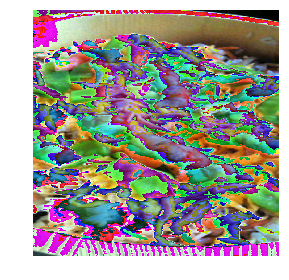

In [63]:
path = '/Users/blanca_alonso/Documents/cookpad/data/sushi_or_sandwich/sushi/'

im = take_sample(path)

im_= np.expand_dims(im, 0)
print(im.min(), im.max(), im.mean(), im.std())

im = preprocess_input_function(im, 'xception', crop='centered')
print(im.min(), im.max(), im.mean(), im.std())

plot_im(im*255)